In [57]:
import os
import time

import numpy as np
import scipy.sparse as sp


In [58]:
# Get PATH environment variable
path = os.environ['PATH']
# Remove ;.; from PATH
path = path.replace(';.;', '')
# Set PATH environment variable
os.environ['PATH'] = path


In [59]:
import matplotlib.pyplot as plt
import pbatoolkit as pbat

In [60]:
def check_condition_number(A):
    if sp.issparse(A):
        A_dense = A.toarray()
    else:
        A_dense = A
    cond_num = np.linalg.cond(A_dense)
    print(f"Condition number of matrix A: {cond_num}")

In [61]:
def generate_identity_test_data(size):
    """Generates identity matrix and a simple vector."""
    A = np.identity(size)
    b = np.random.randn(size)
    return sp.csr_matrix(A), b

In [62]:
def generate_test_data(size):
    """Generates random SPD matrix and vector."""
    A = np.random.randn(size, size)
    A = np.dot(A.T, A)  # Ensure SPD matrix
    b = np.random.randn(size)
    
    return sp.csr_matrix(A), b  # Return CSR sparse matrix format

In [63]:
def validate_solution(A, b, x, tol=1e-2):
    """Validates that the solution x satisfies Ax = b within a given tolerance."""
    if sp.issparse(A):
        residual = A.dot(x) - b  # Sparse matrix dot product with vector x
    else:
        residual = np.dot(A, x) - b  # Dense matrix dot product with vector x

    residual_norm = np.linalg.norm(residual)
    print(f"Residual norm: {residual_norm}")
    
    if residual_norm < tol:
        print("Solution is valid.")
        return True
    else:
        print("Solution is invalid.")
        return False


In [64]:
def test_ldlt(A, b):
    """Test LDLT solver and validate the solution."""
    if not isinstance(A, (sp.csr_matrix, sp.csc_matrix)):
        raise TypeError("Argument A should be either of scipy.sparse.csc_matrix or scipy.sparse.csr_matrix")
    
    start_time = time.time()
    solver = pbat.math.linalg.ldlt(A)
    solver.compute(A)
    x = solver.solve(b).flatten()
    elapsed_time = time.time() - start_time

    print(f"Solution x: {x}")
    print(f"Right-hand side b: {b}")
    print(f"Matrix A:\n{A.toarray()}")

    residual = A.dot(x) - b
    residual_norm = np.linalg.norm(residual)
    print(f"LDLT solver residual: {residual_norm}")

    assert validate_solution(A, b, x), "LDLT solver failed to produce a correct solution."

    return elapsed_time


In [65]:
def test_chol(A, b):
    """Test Cholesky solver with SuiteSparse and validate the solution."""
    start_time = time.time()
    solver = pbat.math.linalg.chol(A, solver=pbat.math.linalg.SolverBackend.SuiteSparse)
    solver.compute(sp.tril(A), pbat.math.linalg.Cholmod.SparseStorage.SymmetricLowerTriangular)
    x = solver.solve(b).flatten()
    elapsed_time = time.time() - start_time

    print(f"Cholesky Solution x: {x}")
    print(f"Right-hand side b: {b}")
    print(f"Matrix A:\n{A.toarray()}")

    residual = A.dot(x) - b
    residual_norm = np.linalg.norm(residual)
    print(f"Cholesky solver residual: {residual_norm}")

    assert validate_solution(A, b, x), "Cholesky solver failed to produce a correct solution."

    return elapsed_time


In [66]:
def test_pgs(A, b, lower_bounds, upper_bounds, max_iter):
    """Test PGS solver and validate the solution."""
    start_time = time.time()
    x = pbat.math.linalg.pgs(A, b, lower_bounds=lower_bounds, upper_bounds=upper_bounds, max_iter=max_iter)
    elapsed_time = time.time() - start_time

    print(f"PGS Solution x: {x}")
    print(f"Right-hand side b: {b}")
    print(f"Matrix A:\n{A.toarray()}")

    residual = A.dot(x) - b
    residual_norm = np.linalg.norm(residual)
    print(f"PGS solver residual norm: {residual_norm}")

    if not validate_solution(A, b, x):
        print("PGS solver failed to produce a correct solution.")
    else:
        print("PGS solver produced a valid solution.")

    return elapsed_time



In [67]:
def test_pgssm(A, b, lower_bounds, upper_bounds, max_iter, sub_iter):
    """Test PGSSM solver and validate the solution."""
    start_time = time.time()
    x = pbat.math.linalg.pgssm(A, b, lower_bounds=lower_bounds, upper_bounds=upper_bounds, max_iter=max_iter, sub_iter=sub_iter)
    elapsed_time = time.time() - start_time

    print(f"PGSSM Solution x: {x}")
    print(f"Right-hand side b: {b}")
    print(f"Matrix A:\n{A.toarray()}")

    residual = A.dot(x) - b
    residual_norm = np.linalg.norm(residual)
    print(f"PGSSM solver residual norm: {residual_norm}")

    if not validate_solution(A, b, x):
        print("PGSSM solver failed to produce a correct solution.")
    else:
        print("PGSSM solver produced a valid solution.")

    return elapsed_time


In [68]:
def compare_solvers(size, max_iter, sub_iter, use_identity=False):
    if use_identity:
        A, b = generate_identity_test_data(size)
    else:
        A, b = generate_test_data(size)

    lower_bounds = np.zeros(size)
    upper_bounds = np.ones(size) * 5.0

    print(f"Testing with size: {size}")
    check_condition_number(A)  # Check the condition number

    # Test LDLT
    ldlt_time = test_ldlt(A, b)
    print(f"LDLT Time: {ldlt_time:.4f} s")

    # Test Cholesky (SuiteSparse)
    chol_time = test_chol(A, b)
    print(f"Cholesky Time (SuiteSparse): {chol_time:.4f} s")

    # Test PGS
    pgs_time = test_pgs(A, b, lower_bounds, upper_bounds, max_iter)
    print(f"PGS Time: {pgs_time:.4f} s")

    # Test PGSSM
    pgssm_time = test_pgssm(A, b, lower_bounds, upper_bounds, max_iter, sub_iter)
    print(f"PGSSM Time: {pgssm_time:.4f} s")

    return ldlt_time, chol_time, pgs_time, pgssm_time


In [69]:
def plot_performance(sizes, ldlt_times, chol_times, pgs_times, pgssm_times):
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, ldlt_times, label='LDLT Time', marker='o')
    plt.plot(sizes, chol_times, label='Cholesky (SuiteSparse) Time', marker='s')
    plt.plot(sizes, pgs_times, label='PGS Time', marker='^')
    plt.plot(sizes, pgssm_times, label='PGSSM Time', marker='x')
    plt.xlabel('Matrix Size')
    plt.ylabel('Time (seconds)')
    plt.title('Performance of Solvers (LDLT vs Cholesky vs PGS vs PGSSM)')
    plt.legend()
    plt.grid(True)
    plt.show()


Testing with size: 1
Condition number of matrix A: 1.0
Solution x: [-0.66943919]
Right-hand side b: [-0.66943919]
Matrix A:
[[1.]]
LDLT solver residual: 0.0
Residual norm: 0.0
Solution is valid.
LDLT Time: 0.0000 s
Cholesky Solution x: [-0.66943919]
Right-hand side b: [-0.66943919]
Matrix A:
[[1.]]
Cholesky solver residual: 0.0
Residual norm: 0.0
Solution is valid.
Cholesky Time (SuiteSparse): 0.0010 s
PGS Solution x: [0.]
Right-hand side b: [-0.66943919]
Matrix A:
[[1.]]
PGS solver residual norm: 0.6694391884843482
Residual norm: 0.6694391884843482
Solution is invalid.
PGS solver failed to produce a correct solution.
PGS Time: 0.0000 s
PGSSM Solution x: [0.]
Right-hand side b: [-0.66943919]
Matrix A:
[[1.]]
PGSSM solver residual norm: 0.6694391884843482
Residual norm: 0.6694391884843482
Solution is invalid.
PGSSM solver failed to produce a correct solution.
PGSSM Time: 0.0000 s
Testing with size: 2
Condition number of matrix A: 1.0
Solution x: [-0.26574179  0.77952223]
Right-hand side

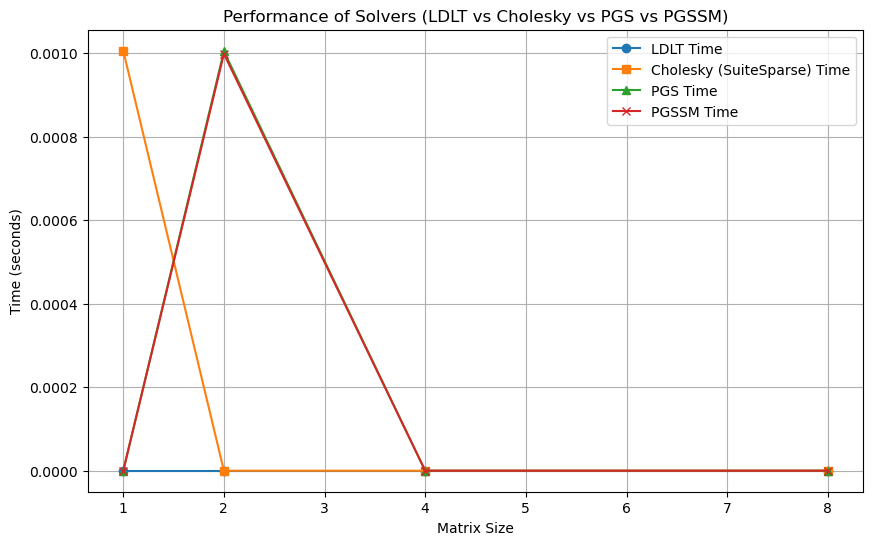

In [70]:
if __name__ == "__main__":
    sizes = [1, 2, 4, 8]
    max_iter = 100
    sub_iter = 1

    ldlt_times = []
    chol_times = []
    pgs_times = []
    pgssm_times = []

    for size in sizes:
        ldlt_time, chol_time, pgs_time, pgssm_time = compare_solvers(size, max_iter, sub_iter, use_identity=True)  # Switch use_identity to True for identity test
        ldlt_times.append(ldlt_time)
        chol_times.append(chol_time)
        pgs_times.append(pgs_time)
        pgssm_times.append(pgssm_time)

    plot_performance(sizes, ldlt_times, chol_times, pgs_times, pgssm_times)